In [537]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats

In [554]:
def load_fits_images(dir: str, observation_date: str) -> tuple:
    """
    Carrega as imagens FITS de um diretório específico, excluindo arquivos desnecessários.

    Parâmetros:
    dir (str): O diretório onde as imagens FITS estão armazenadas.
    observation_date (str): A data da observação para criar o caminho do diretório.

    Retorna:
    tuple: Uma tupla contendo:
        - image_names (list): Lista dos nomes das imagens carregadas.
        - images_data (list): Lista dos dados das imagens carregadas.
    """
    base_path = os.path.join(dir, f'{observation_date}/')
    file_pattern = os.path.join(base_path, '*.fit')
    fits_files = glob.glob(file_pattern)
    image_names = sorted([f for f in fits_files if not ('pg1530-021.fit' <= os.path.basename(f) <= 'pg1530-050.fit')])
    
    images_data = []
    for fits_file in image_names:
        hdu = fits.open(fits_file)
        images_data.append(hdu[0].data)
    
    return image_names, images_data


In [559]:
def calculate_photometry(image_section: np.ndarray, x_star: float, y_star: float, radius_aperture: float) -> tuple:
    """
    Calcula a fotometria para a seção da imagem.

    Parâmetros:
    image_section (np.ndarray): A seção da imagem onde a estrela está localizada.
    x_star (float): A coordenada x da estrela.
    y_star (float): A coordenada y da estrela.
    radius_aperture (float): O raio da abertura circular a ser usada para a fotometria.

    Retorna:
    tuple: Uma tupla contendo:
        - mag (float): A magnitude da estrela calculada.
        - MERR (float): O erro associado à magnitude.
        - annulus (CircularAnnulus): O objeto de anel circular utilizado para calcular o fundo.
    """
    # Criar abertura
    aperture_cropped = CircularAperture((x_star, y_star), r=radius_aperture)
    radius_in = 15         # Raio interno do anel (igual ao IRAF)
    dannulus = 5           # Largura do anel de fundo

    # Annulus
    annulus = CircularAnnulus((x_star, y_star), r_in=radius_in, r_out=radius_in + dannulus)
    
    # Fotometria de abertura
    photometry = aperture_photometry(image_section, aperture_cropped)

    # Contribuição do Céu
    bkg = ApertureStats(image_section, annulus)
    bkg_sum = bkg.sum
    bkg_mean = bkg.mean
    total_bkg = bkg_mean * aperture_cropped.area

    star_flux = photometry["aperture_sum"] - total_bkg
    FERR = np.sqrt(photometry['aperture_sum'][0]) + np.sqrt(bkg_sum)

    zmag = 25  # IRAF
    mag = zmag - 2.5 * np.log10(star_flux) if star_flux > 0 else np.inf

    if star_flux > 0:
        MERR = (1.0857 * FERR) / star_flux[0]
    else:
        MERR = np.inf  # Erro infinito se o fluxo total for zero

    return mag, MERR, annulus

In [556]:
def plot_images(image_names: list, images_data: list, observation_date: str, radius_aperture: float, rows: int = 4, columns: int = 5) -> None:
    """
    Plota as imagens com fotometria e anotações.

    Parâmetros:
    image_names (list): Lista dos nomes das imagens a serem plotadas.
    images_data (list): Lista dos dados das imagens a serem plotadas.
    observation_date (str): A data da observação, usada no título do gráfico.
    radius_aperture (float): O raio da abertura circular a ser usado para a fotometria.
    rows (int, opcional): O número de linhas para a exibição das imagens. Default é 4.
    columns (int, opcional): O número de colunas para a exibição das imagens. Default é 5.

    Retorna:
    None: A função apenas gera um gráfico e não retorna valores.
    """
    fig, axes = plt.subplots(rows, columns, figsize=(20, 10))
    fig.suptitle(f"{observation_date} PG1530+057A", fontsize=20, y=1)

    ims = []  # Para armazenar os objetos de imagem
    for i, image_data in enumerate(images_data):
        image_section = image_data[350:700, 450:910]
        x_cropped_star = 64  # Coordenadas x da estrela
        y_cropped_star = 110  # Coordenadas y da estrela

        # Calcular fotometria e obter o anel
        mag, MERR, annulus = calculate_photometry(image_section, x_cropped_star, y_cropped_star, radius_aperture)

        # Definindo limites de exibição
        vmin = np.percentile(image_data, 1)
        vmax = np.percentile(image_data, 99)

        ax = axes[i // columns, i % columns]
        im = ax.imshow(image_section, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        ims.append(im)

        # Adicionar informações como labels na imagem
        textstr = '\n'.join((
            f"MAG:       {mag[0]:.3f}" if isinstance(mag, np.ndarray) else f"MAG:       {mag:.3f}",
            f"MERR:      {MERR:.3f}",
        ))         
        # Definir a posição do texto
        x_text = 0.05 * image_section.shape[1]
        y_text = 0.95 * image_section.shape[0]
        ax.text(x_text, y_text, textstr, fontsize=10, color='white', ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.2', edgecolor='white', facecolor='black', alpha=0.8))
        ax.set_title(image_names[i].split("/")[-1], fontsize=10, pad=10)

        # Plotar o anel
        annulus.plot(color='blue', lw=1.5, ax=ax, label='Annulus')

    # Criar uma única colorbar para todos os subplots na parte inferior
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    cbar = plt.colorbar(ims[0], cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=10)

    # Remover eixos de imagens não utilizadas, se houver
    for j in range(len(images_data), rows * columns):
        axes[j // columns, j % columns].axis('off')

    # Ajustar layout para evitar sobreposições
    plt.subplots_adjust(top=0.93, bottom=0.1, left=0.07, right=0.93, hspace=0.5, wspace=0.2)
    plt.savefig(observation_date)
    plt.show()

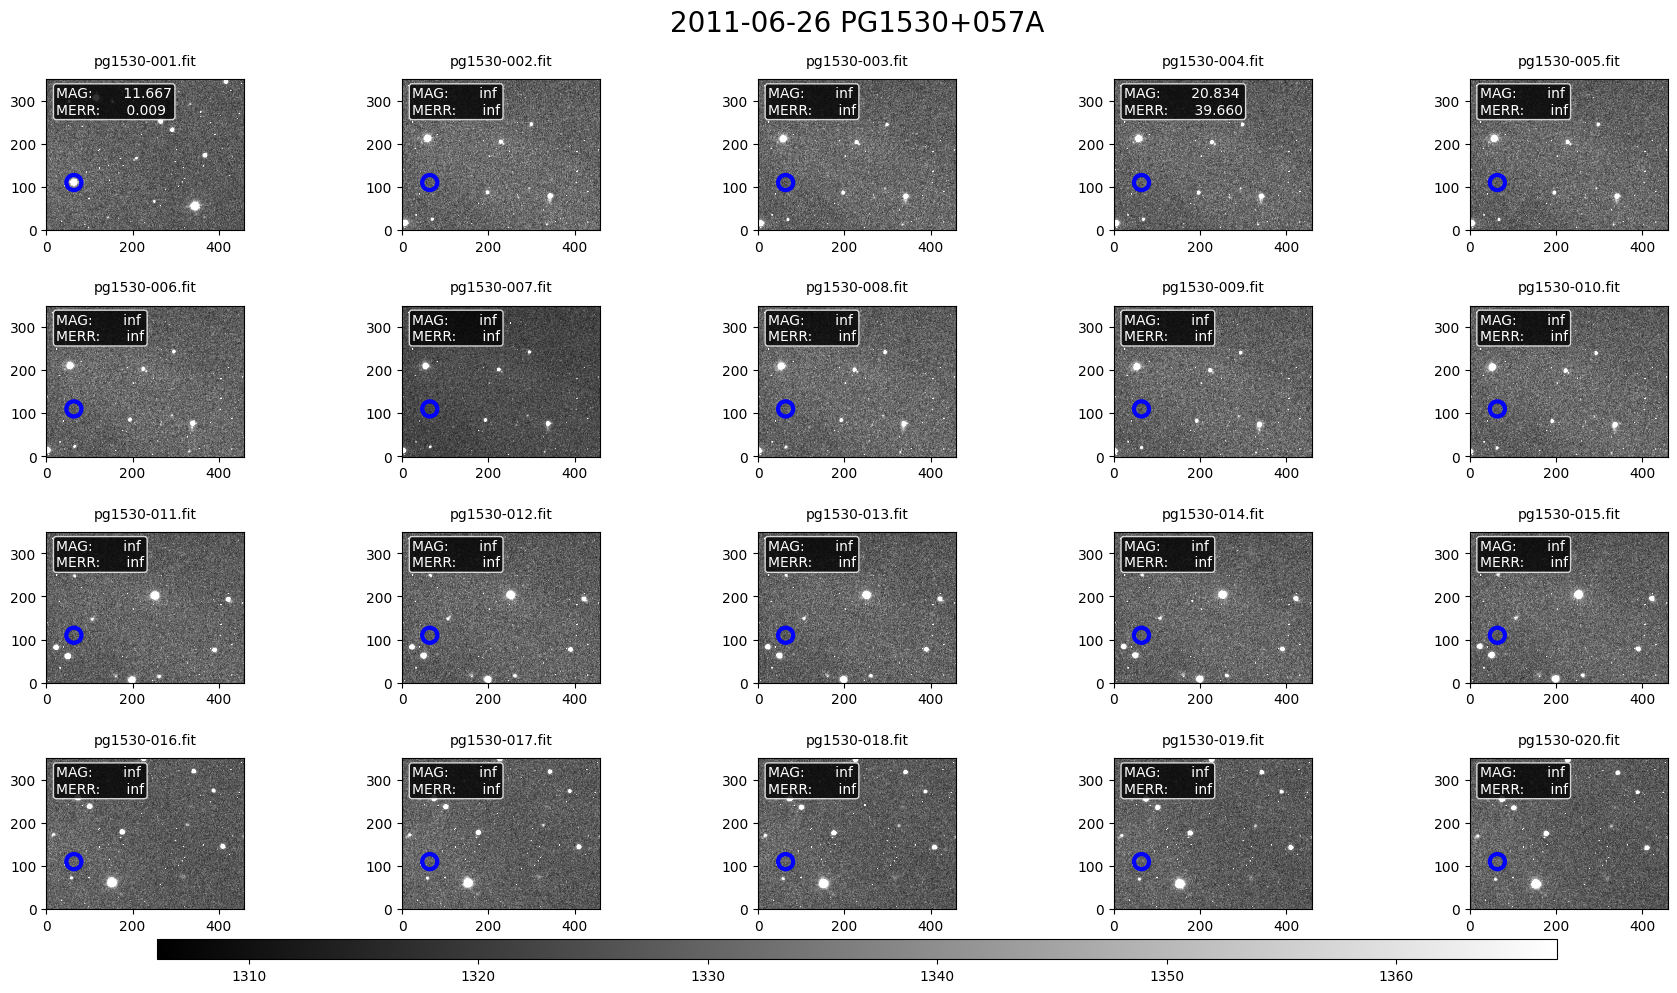

Image observations/2011-06-26/pg1530-001.fit: MAG = 11.667
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
Image observations/2011-06-26/pg1530-004.fit: MAG = 20.834
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf
MAG:       inf, MERR = inf


In [567]:
# Configurações iniciais
dir = "observations/"
observation_date = "2011-06-26"
radius_aperture = 13

# Carregar as imagens FITS
image_names, images_data = load_fits_images(dir, observation_date)

# Definindo as coordenadas da estrela
x_star = 64
y_star = 110

# Lista para armazenar os resultados
results = []

# Iterar sobre cada imagem e calcular a fotometria
for image_data in images_data:
    # Extraindo a seção da imagem
    image_section = image_data[350:700, 450:910]

    # Calcular a fotometria
    mag, MERR, annulus = calculate_photometry(image_section, x_star, y_star, radius_aperture)

    # Armazenar os resultados
    results.append((mag, MERR))

# Plota as imagens com a fotometria
plot_images(image_names, images_data, observation_date, radius_aperture)

# Exibir os resultados da fotometria
for i, (mag, merr) in enumerate(results):
    print(f"Image {image_names[i]}: MAG = {mag[0]:.3f}" if isinstance(mag, np.ndarray) else f"MAG:       {mag:.3f}, MERR = {merr:.3f}")